<a href="https://colab.research.google.com/github/wtkns/birdsong/blob/main/birdsong.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from skimage.color import rgb2hsv, rgb2gray, rgb2yuv
from skimage import color, exposure, transform
from skimage.exposure import equalize_hist
import random

In [2]:
def random_line(fname):
    lines = open(fname).read().splitlines()
    return random.choice(lines)

def random_bird():
    name = '-'.join((random_line('color-names.txt'),random_line('part-names.txt'),random_line('family-names.txt')))
    return name



persimmon-crested-Jayshrike
gold-crowned-Mousebird
wheat-winged-Cupwing
sapphire-headed-Parrot
navy-blue-tailed-Whydah
black-thighed-Skua
navy-blue-beaked-Wrenthrush
quartz-grey-toed-Babbler
shocking-pink-naped-Piopio
thistle-cheeked-Goldcrests


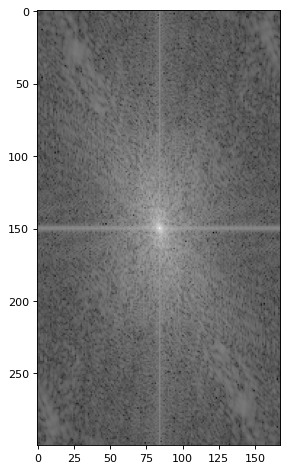

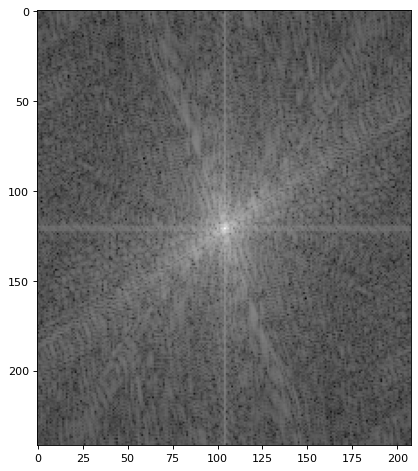

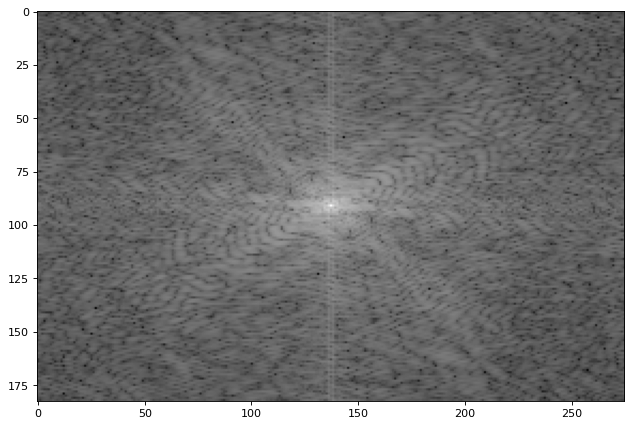

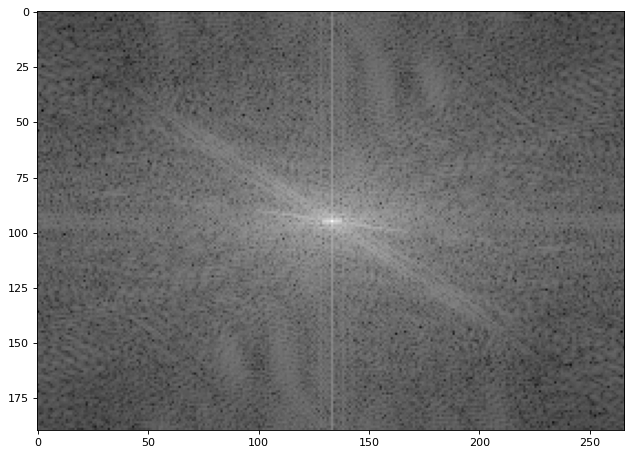

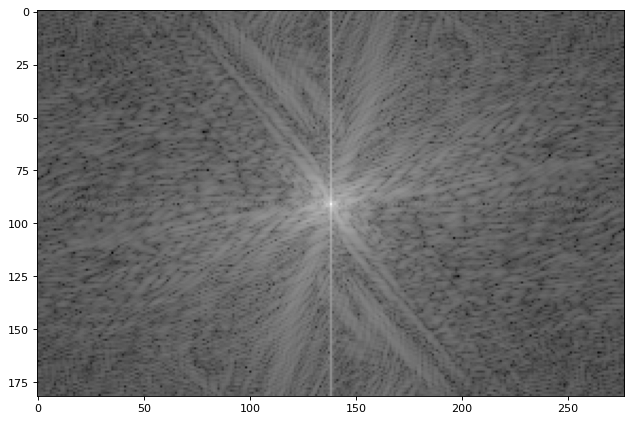

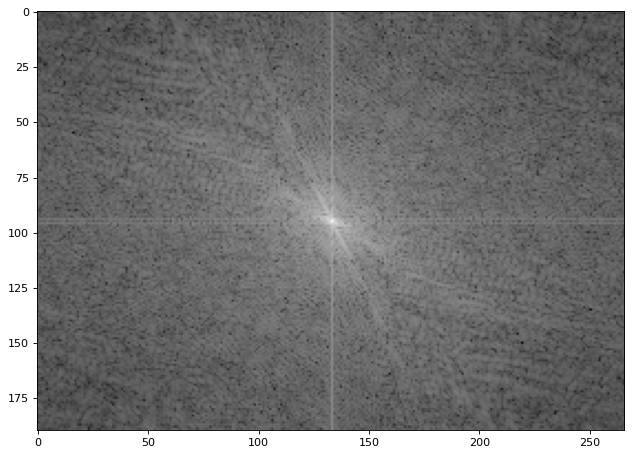

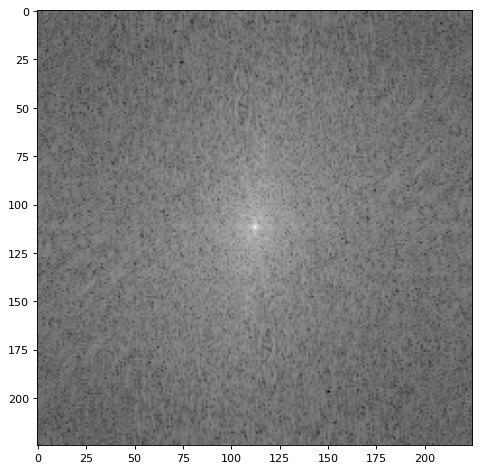

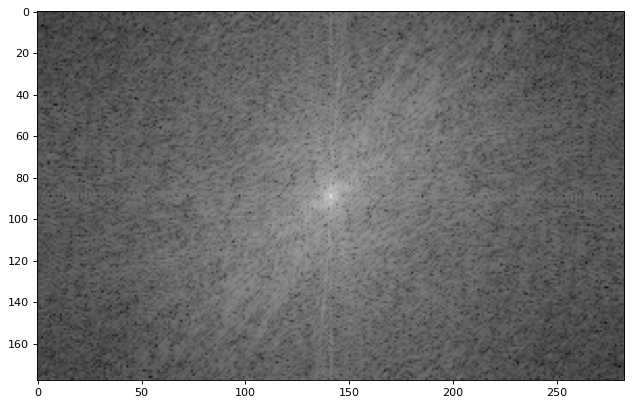

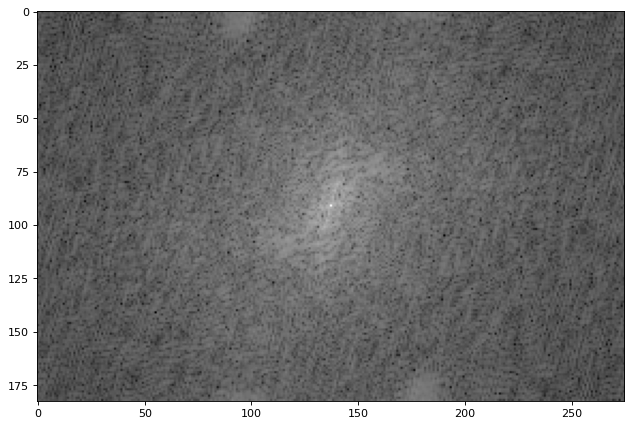

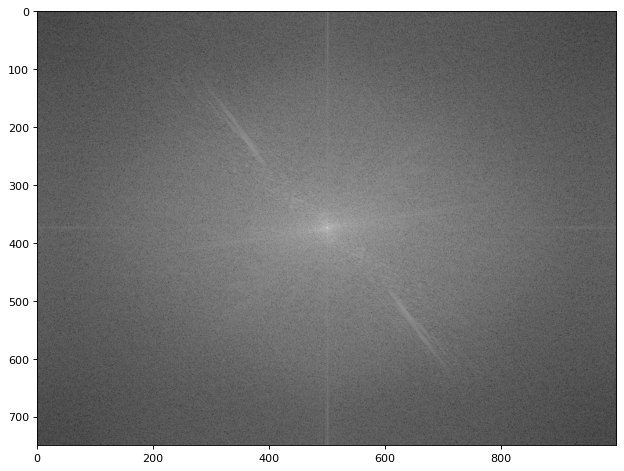

In [14]:
os.chdir('/content/drive/MyDrive/DX499/')


bird_images = {}


for image in os.listdir('bird-images'):
  imgfile = "/".join(("bird-images", image))
  # print(imgfile)
  print(random_bird())
  bird_images[image] = imread(imgfile)
  plt.figure(num=None, figsize=(8, 6), dpi=80)
  image_grey = rgb2gray(bird_images[image])
  image_fourier = np.fft.fftshift(np.fft.fft2(image_grey))

  imshow(imread(imgfile))
  plt.imshow(np.log(abs(image_fourier)), cmap='gray');


In [ ]:
!sudo apt-get install build-essential cmake libjack-jackd2-dev libsndfile1-dev libfftw3-dev libxt-dev libavahi-client-dev
!sudo apt-get install git libasound2-dev libicu-dev libreadline6-dev libudev-dev pkg-config libncurses5-dev

!git clone --recursive https://github.com/supercollider/supercollider.git

import os
os.chdir('supercollider')

!git checkout Version-3.12.2

os.makedirs('build')
os.chdir('build')

!cmake -DSC_QT=OFF -DCMAKE_BUILD_TYPE=Release -DNATIVE=ON -DNO_X11=ON -DSC_EL=no ..
!make -j3
!sudo make install

# if we end up needing sc3-plugins:

# os.chdir('/content')
# !git clone --recursive https://github.com/supercollider/sc3-plugins.git
# os.makedirs('sc3-plugins/build')
# os.chdir('sc3-plugins/build')

# !cmake -DSC_PATH=/content/supercollider -DCMAKE_BUILD_TYPE=Release -DSUPERNOVA=ON ..
# !cmake --build . --config Release
# !sudo cmake --build . --config Release --target install

# !sclang -v
# !echo '"hello world".postln;'>test.scd
# !sclang ./test.scd

In [37]:
os.chdir('/content')
os.makedirs('output')

In [38]:
%%writefile hansm-bird-nrt.scd
/* hansm-bird-control.pd
http://obiwannabe.co.uk/tutorials/html/tutorial_birds.html
SC port by redFrik 080430 */

  var myPath = "./output/" ++ thisProcess.argv[0] ++ ".wav";
  var argfreq = thisProcess.argv[1].asFloat;
  var argatk = thisProcess.argv[2].asFloat;
  var argdcy = thisProcess.argv[3].asFloat;
  var argfmod1 = thisProcess.argv[4].asFloat;
  var argatkf1 = thisProcess.argv[5].asFloat;
  var argdcyf1 = thisProcess.argv[6].asFloat;
  var argfmod2 = thisProcess.argv[7].asFloat;
  var argatkf2 = thisProcess.argv[8].asFloat;
  var argdcyf2 = thisProcess.argv[9].asFloat;
  var argamod1 = thisProcess.argv[10].asFloat;
  var argatka1 = thisProcess.argv[11].asFloat;
  var argdcya1 = thisProcess.argv[12].asFloat;
  var argamod2 = thisProcess.argv[13].asFloat;
  var argatka2 = thisProcess.argv[14].asFloat;
  var argdcya2 = thisProcess.argv[15].asFloat;

  var server = Server(\nrt,
      options: ServerOptions.new
      .numOutputBusChannels_(2)
  );

  var birdsynth = SynthDef(\birdCall, {|
			out= 0, pan= 0, gate= 1, freq= 0, amp= 0.5, atk= 0.5, dcy= 0.5,
			fmod1= 1, atkf1= 0.5, dcyf1= 0.5,
			fmod2= 1, atkf2= 0.5, dcyf2= 0.5,
			amod1= 1, atka1= 0.5, dcya1= 0.5,
			amod2= 1, atka2= 0.5, dcya2= 0.5|

			var env, freq1, freq2, amp1, amp2, fmod, amod, z;
			env= EnvGen.ar(Env([0, amp, 0], [atk, dcy], -4), gate, timeScale:0.9, doneAction:2);
			freq1= EnvGen.ar(Env([0, fmod1, 0], [atkf1, dcyf1], -4), 1, 3000, 0, 0.9);
			freq2= EnvGen.ar(Env([0, fmod2, 0], [atkf2, dcyf2], -4), 1, 3000, 0, 0.9);
			amp1= EnvGen.ar(Env([0, amod1, 0], [atka1, dcya1], -4), 1, 1, 0, 0.9);
			amp2= EnvGen.ar(Env([0, amod2, 0], [atka2, dcya2], -4), 1, 1, 0, 0.9);
			fmod= SinOsc.ar(freq1, 0, amp1, 1);
			amod= 1-SinOsc.ar(freq2, 0, amp2);
			z= SinOsc.ar(freq*7000+300*fmod, 0, amod);
			Out.ar(out, Pan2.ar(z, pan, env));
	});

  var myScore = Score([
      [0.0, ['/d_recv',birdsynth.asBytes]],
      [0.0, (x = Synth.basicNew(\birdCall, server)).newMsg(
      args: [freq: argfreq, atk: argatk, dcy: argdcy,
      fmod1: argfmod1, atkf1: argatkf1, dcyf1: argdcyf1,
      fmod2: argfmod2, atkf2: argatkf2, dcyf2: argdcyf2,
      amod1: argamod1, atka1: argatka1, dcya1: argdcya1,
      amod2: argamod2, atka2: argatka2, dcya2: argdcya2]
      )],
      [1.0, x.freeMsg]
  ]);

  var myRoutine = Routine.new({
      var cond = Condition.new;
      
      myScore.recordNRT(
        outputFilePath:myPath.standardizePath,
        headerFormat: "WAV",
        sampleFormat: "int16",
        options: server.options,
        action: { cond.unhang }
      );

      cond.hang;	
      "done".postln;	
      0.exit;
      
  }); // end Routine

  myRoutine.play;  // 'play' is a shortcut for scheduling the routine on a clock


Writing hansm-bird-nrt.scd


In [13]:
%%writefile part-names.txt 
headed
beaked
chinned
eyed
throated
winged
thighed
tarsused
footed
tailed
rumped
backed
naped
crowned
bellied
crested
toed
collared
cheeked
billed
spotted

Overwriting part-names.txt


In [5]:
%%writefile color-names.txt 
amaranth
amber
amethyst
apricot
aqua
aquamarine
asparagus
auburn
azure
beige
black
blue
blue-green
blue-violet
bondi-blue
brass
bronze
brown
buff
burgundy
camouflage-green
caput-mortuum
cardinal
carmine
carrot-orange
celadon
cerise
cerulean
champagne
charcoal
chartreuse
cherry-blossom-pink
chestnut
chocolate
cinnabar
cinnamon
cobalt
copper
coral
corn
cornflower
cream
crimson
cyan
dandelion
denim
ecru
emerald
eggplant
fern-green
firebrick
flax
forest-green
french-rose
fuchsia
gold
goldenrod
green
grey
purple
harlequin
heliotrope
cerise
indigo
ivory
jade
kelly-green
khaki
lavender
lemon
lilac
lime
linen
magenta
magnolia
malachite
maroon
mauve
midnight-blue
mint-green
misty-rose
moss-green
mustard
myrtle
navy-blue
ochre
olive
olivine
orange
orchid
papaya
peach
pear
periwinkle
persimmon
pine-green
pink
platinum
plum
powder-blue
puce
prussian-blue
psychedelic-purple
pumpkin
purple
quartz-grey
raw-umber
razzmatazz
red
robin-egg-blue
rose
royal-blue
royal-purple
ruby
russet
rust
orange
saffron
salmon
sandy-brown
sangria
sapphire
scarlet
school-bus-yellow
sea-green
seashell
sepia
shamrock-green
shocking-pink
silver
sky-blue
slate-grey
smalt
spring-bud
spring-green
steel-blue
tan
tangerine
taupe
teal
tenné-(tawny)
terra-cotta
thistle
titanium-white
tomato
turquoise
tyrian-purple
ultramarine
van-dyke-brown
vermilion
violet
viridian
wheat
white
wisteria
yellow
zucchini

Overwriting color-names.txt


In [7]:
%%writefile family-names.txt 
Ostrich
Rhea
Kiwi
Cassowarie
Emu
Tinamou
Screamer
Magpie
Goose
Megapode
Chachalaca
Curassow
Guan
Guineafowl
Quail
Pheasant
Frogmouth
Oilbird
Potoo
Nightjar
Owlet
Treeswift
Swift
Hummingbird
Turaco
Bustard
Cuckoo
Mesite
Sandgrouse
Pigeon
Dove
Finfoot
Flufftail
Rail
Crake
Coots
Trumpeter
Crane
Limpkin
Grebe
Flamingo
Buttonquail
Stone-curlew
Thick-knee
Sheathbill
Magellanic-Plover
Oystercatcher
Ibis
Stilt
Avocet
Plover
Egyptian-Plover
Painted-snipe
Jacana
Plains-wanderer
Seedsnipe
Sandpiper
Snipe
Crab-plover
Coursers
Pratincole
Gull
Tern
Skimmer
Skua
Auk
Kagu
Sunbittern
Tropicbird
Loon
Penguin
Albatross
Petrel
Shearwaters
Diving-Petrels
Stork
Frigatebird
Gannet
Boobie
Anhinga
Darter
Cormorant
Shag
Ibis
Spoonbill
Heron
Bittern
Hamerkop
Shoebill
Pelicans
Hoatzin
Vulture
Secretarybird
Osprey
Kite
Hawk
Eagle
Barn-Owl
Owl
Mousebird
Cuckoo-Roller
Trogon
Hoopoe
Wood-Hoopoe
Ground-Hornbill
Hornbill
Roller
Ground-Roller
Kingfisher
Todie
Motmot
Bee-eater
Jacamar
Puffbird
Barbet
Toucans
Barbets
Barbets
Honeyguide
Woodpecker
Seriema
Caracara
Falcon
Parrot
Cockatoo
Wren
Sapayoa
Asitie
Broadbill
Pitta
Ovenbird
Antbird
Antthrushe
Antpitta
Gnateater
Tapaculo
Crescentchest
Tyrant-Flycatcher
Cotinga
Manakin
Sharpbill
Tityra
Becard
Lyrebird
Scrubbird
Bowerbird
Treecreeper
Honeyeater
Bristlebird
Pardalote
Warbler
Babbler
Logrunner
Satinbird
Berrypecker
Longbill
Wattlebird
Stitchbird
Whipbird
Jewel-babbler
Quail-thrush
Wattle-eye
Batis
Bushshrike
Boatbill
Vanga
Helmetshrike
Woodshrike
Shrike-flycatcher
Bristlehead
Woodswallow
Butcherbird
Peltop
Berryhunter
Iora
Cuckooshrike
Whitehead
Sittella
Ploughbill 
Bellbird
Shriketit
Whistler
Shrikes
Vireo
Greenlets
Shrike-babbler
Figbird
Oriole
Piopio
Drongo
Fantail
Silktail
Monarch
Jayshrike
Crow
Jay
Mudnester
Melampitta
Ifrita
Bird-of-paradise
Robin
Rockfowl
Rockjumper
Rail-babbler
Waxwing
Silky-flycatcher
Hypocolius
Palmchat
Oos
Hylocitrea
Fairy-Flycatcher
Tit
Chickadee
Penduline-Tit
Nicator
Bearded-Reedling
Lark
Bulbul
Swallow
Martin
Cupwing
Crombec
Bush-Warbler
Scrub-Warbler
Flycatcher
Hylia
Bushtit
Leaf-Warbler
Reed-Warbler
Grauers-Warbler
Grassbird
Black-capped-Donacobius
Warbler
Cisticola
Sylviid-Babbler
Parrotbill
White-eye
Babbler
Scimitar-Babbler
Ground-Babbler
Alcippe-Fulvetta
Laughingthrush
Dapple-throat
Sugarbird
Fairy-bluebird
Goldcrests
Kinglet
Elachura
Hyliot
Wren
Gnatcatcher
Nuthatch
Wallcreeper
Treecreeper
Mockingbird
Thrasher
Starling
Rhabdornis
Oxpecker
Thrushes
Chat
Flycatcher
Dipper
Leafbird
Flowerpecker
Sunbird
Sparrow
Snowfinch
Weaver
Widowbirds
Waxbill
Munia
Indigobird
Whydah
Olive-Warbler
Accentor
Wagtail
Pipit
Przevalskis-Finch
Finches
Euphonia
Longspur
Snow-Bunting
Thrush-tanager
Bunting
Sparrow
Bush-Tanagers
Chat-tanager
Tanagers
Tanager
Spindalise
Wrenthrush
Cuban-Warbler
Chat
Oropendola
Oriole
Blackbird
Warbler
Mitrospingid-Tanager
Cardinal
Tanager

Writing family-names.txt


In [42]:
%%writefile example-birds.txt
triple-tailed-tree-troubler 0.387755 0.0204082 0.204082 0.367347 0.571429 0.734694 0.918367 1 0.77551 0.571429 0.367347 0.22449 0.0204082 0.183673 0.44898
speckled-throated-spew 0.183673 0.591837 0.387755 0.0104082 0.530612 0.346939 0.244898 0.55102 0.122449 0.387755 1 0.612245 0.346939 0.816327 0.653061
lesser-spotted-grinchwarbler 0.55102 0.591837 0.387755 0.0716327 0.0204082 0.346939 0.0204082 0.55102 0.122449 0.632653 1 0.612245 0.346939 0.816327 0.653061
long-toed-mudhopper 0.163265 0.22449 0.183673 0.00306122 0.122449 1 0.0612245 1 0.77551 0.979592 0.204082 0.734694 1 0.142857 0.612245
yellow-yiffled-yaffle 0.0204082 0.367347 0.183673 0.0612245 0 1 0.285714 0.22449 0.489796 0.367347 0.387755 0.734694 0.204082 0.428571 0.142857
pointy-beaked-beetlefiend 0.428571 0.204082 0.489796 0.0204082 0.795918 0.591837 0.285714 0.22449 0.489796 0.204082 0.836735 0.734694 0.77551 0.428571 0.142857
african-boojuboolubala 0.306122 0.959184 0.0408163 1 0 0.591837 0.285714 0.22449 0.489796 0.204082 0.836735 0.734694 0.77551 0.428571 0.142857
common-muckoink 0.0204082 0.8 0.0816327 0.0204082 0.001 0.99 0.0204082 0.01 1 1 0.142857 0.734694 1 0.0612245 0.530612

Writing example-birds.txt


In [43]:
# for running ffmpeg
import subprocess
import sys

def generate_birdsong(parameter_list):

  sc_command_string = 'sclang ./hansm-bird-nrt.scd '
  sc_command_string += ' '.join(parameter_list)

  result = subprocess.Popen(sc_command_string, stdout = subprocess.PIPE, stderr = subprocess.STDOUT, shell=True)
  stdout, stderr = result.communicate()
  
  return (str(stdout))

In [44]:
def parameter_dict_to_list(parameter_dict):
  parameter_list = []
  parameter_list.append(parameter_dict['name'])
  parameter_list.append(parameter_dict['freq'])
  parameter_list.append(parameter_dict['atk'])
  parameter_list.append(parameter_dict['dcy'])
  parameter_list.append(parameter_dict['fmod1'])
  parameter_list.append(parameter_dict['atkf1'])
  parameter_list.append(parameter_dict['dcyf1'])
  parameter_list.append(parameter_dict['fmod2'])
  parameter_list.append(parameter_dict['atkf2'])
  parameter_list.append(parameter_dict['dcyf2'])
  parameter_list.append(parameter_dict['amod1'])
  parameter_list.append(parameter_dict['atka1'])
  parameter_list.append(parameter_dict['dcya1'])
  parameter_list.append(parameter_dict['amod2'])
  parameter_list.append(parameter_dict['atka2'])
  parameter_list.append(parameter_dict['dcya2'])

  return parameter_list

def parameter_list_to_dict(parameter_list):
  parameter_dict = {
    'name'  : str(parameter_list[0]),
    'freq'  : str(parameter_list[1]),
    'atk'   : str(parameter_list[2]),
    'dcy'   : str(parameter_list[3]),
    'fmod1' : str(parameter_list[4]),
    'atkf1' : str(parameter_list[5]),
    'dcyf1' : str(parameter_list[6]),
    'fmod2' : str(parameter_list[7]),
    'atkf2' : str(parameter_list[8]),
    'dcyf2' : str(parameter_list[9]),
    'amod1' : str(parameter_list[10]),
    'atka1' : str(parameter_list[11]),
    'dcya1' : str(parameter_list[12]),
    'amod2' : str(parameter_list[13]),
    'atka2' : str(parameter_list[14]),
    'dcya2' : str(parameter_list[15])
  }

  return parameter_dict

In [45]:
bird_dict = parameter_list_to_dict(['triple-tailed-tree-troubler', 0.387755, 0.0204082, 0.204082, 0.367347, 0.571429, 0.734694, 0.918367, 1, 0.77551, 0.571429, 0.367347, 0.22449, 0.0204082, 0.183673, 0.44898])

print(bird_dict)

bird_list = parameter_dict_to_list(bird_dict)

print(bird_list)

{'name': 'triple-tailed-tree-troubler', 'freq': '0.387755', 'atk': '0.0204082', 'dcy': '0.204082', 'fmod1': '0.367347', 'atkf1': '0.571429', 'dcyf1': '0.734694', 'fmod2': '0.918367', 'atkf2': '1', 'dcyf2': '0.77551', 'amod1': '0.571429', 'atka1': '0.367347', 'dcya1': '0.22449', 'amod2': '0.0204082', 'atka2': '0.183673', 'dcya2': '0.44898'}
['triple-tailed-tree-troubler', '0.387755', '0.0204082', '0.204082', '0.367347', '0.571429', '0.734694', '0.918367', '1', '0.77551', '0.571429', '0.367347', '0.22449', '0.0204082', '0.183673', '0.44898']


In [46]:
generate_birdsong(bird_list)

'b"compiling class library...\\n\\tFound 738 primitives.\\n\\tCompiling directory \'/usr/local/share/SuperCollider/SCClassLibrary\'\\n\\tCompiling directory \'/usr/local/share/SuperCollider/Extensions\'\\n\\tnumentries = 679892 / 7365942 = 0.092\\n\\t3973 method selectors, 1854 classes\\n\\tmethod table size 9890224 bytes, big table size 58927536\\n\\tNumber of Symbols 9257\\n\\tByte Code Size 265366\\n\\tcompiled 229 files in 0.17 seconds\\n\\nInfo: 4 methods are currently overwritten by extensions. To see which, execute:\\nMethodOverride.printAll\\n\\ncompile done\\nlocalhost : setting clientID to 0.\\ninternal : setting clientID to 0.\\nCouldn\'t set realtime scheduling priority 1: Operation not permitted\\nClass tree inited in 0.01 seconds\\n\\n\\n*** Welcome to SuperCollider 3.12.2. *** For help type ctrl-c ctrl-h (Emacs) or :SChelp (vim) or ctrl-U (sced/gedit).\\nCouldn\'t set realtime scheduling priority 1: Operation not permitted\\nnrt : setting clientID to 0.\\nstart time 0\\n

In [47]:
example_file = open("example-birds.txt", "r")
raw_examples_list = example_file.readlines()
example_list = []
for example in raw_examples_list:
  example_list.append(example.split(" "))

for example in example_list:
  generate_birdsong(example)



In [49]:
import IPython

directory = 'output'
 
# iterate over files in
# that directory
for filename in os.listdir(directory):
    print(filename)

NameError: ignored